In [1]:
# Imports
import PySimpleGUI as sg
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import os
import scipy
import numpy as np
from PIL import Image, ImageTk
import random
import json 
import metrics


In [2]:
# Grab working directory
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# Load Object Dict (Object # ID: Object Name)
with open('object_dict.json', mode='r') as f:
    object_dict = json.load(f)

# Flip Dict (Object Name: Object # ID)
object_dict_flipped = {value: key for key, value in object_dict.items()}


# Muscle list for dropdown menu TODO: All muscles indexing is wrong 
muscle_list = ['All Muscles', 'DELT1', 'DELT2', 'DELT3', 'SUPRA', 'INFRA', 'SUBSCAP', 'TMIN', 'TMAJ',
               'PMAJ1', 'PMAJ2', 'PMAJ3', 'LAT1', 'LAT2', 'LAT3', 'CORB', 'TRIlong', 'TRIllat', 'TRIlmat', 
               'ANC', 'SUP', 'BIClong', 'BICshort', 'BRA', 'BRD', 'ECRL', 'ECRB', 'ECU', 'FCR', 'FCU', 
               'PL', 'PT', 'PQ', 'FDSL', 'FDSR', 'FDSM', 'FDSI', 'FDPL', 'FDPR', 'FDPM', 'FDPI',
               'EDCL','EDCR', 'EDCM', 'EDCI', 'EDM', 'EIP', 'EPL', 'EPB', 'FPL', 'APL']

# Create dictionary from muscle list 
muscle_dict = {muscle: index - 1 for index, muscle in enumerate(muscle_list)}

# Delete objects with no output associated (usually no pic for >=7 objects and no data for <7)
delete_objs = ['cube4', 'hcyl3', 'hcyl7', 'box1', 'box7', 'ring5', 'ring7', 'sphere1', 'sphere5', 'sphere7', 'sphere8', 'cube7']
for obj in delete_objs:
    del object_dict_flipped[obj]

# Convert to lists for GUI dropdowns 
t_list = list(object_dict_flipped.keys())
object_list = list(object_dict_flipped.keys())

In [3]:
# Given an object name, find the first trial that corresponds to that object
    #TODO: Change to averaged across all trials of the same object 
def find_trial_from_object(object_idxs, object_name):
    object_id = object_dict_flipped.get(object_name)
    indexes = np.where(object_idxs == int(object_id))
    if (len(indexes)) == 0: 
        print("Object not found. Please select a different object.")
        #idk do something??   
        # Note: indexes[0] gives array, indexes[0][0] gives first item in array 
    first_trial_object = int(indexes[0][0])
    try:
        exp_data = mat_data['targ'][0][int(indexes[0][0])]
        exp_data = pd.DataFrame(exp_data, index = muscle_list[1:])
        model_data = mvm_data_full[int(indexes[0][0])]
    except: 
        print("Object not found in list")
        zero_data = np.zeros(shape=(100, 100))
        d = pd.DataFrame(zero_data)
        return d, d
    return exp_data, model_data, first_trial_object 


def plot_data(output_data, muscle, expt_data):
    if muscle_dict[muscle] > -1:
        output_data = output_data[:, muscle_dict[muscle]]
    else: 
        # TODO: Figure out what to do here. We want to prevent the user from selecting All Muscles *while* expt_data is already selected
        # (and therefore a single muscle was already selected). How/Should we go back to the single muscle or should we deselect the expt_data
        # if expt_data:
        #     print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
        #     pass    
        output_data = output_data
    # output_data = output_data[220:]
    output_data.tolist()
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.plot(output_data, label = "Output Data")
    if expt_data:
        expt_data_plot = mvm_data_expt.loc[muscle_name]
        # expt_data_plot = expt_data_plot[220:298]
        ax.plot(expt_data_plot, label = "Expt Data")
    ax.set_xlabel('Time')
    ax.set_ylabel('Muscle Velocity')
    ax.set_title(muscle_name)
    ax.set_xlim(left = 220)
    if muscle_dict[muscle] > -1: # im so sorry code quality 
        plt.legend()
    return fig

# Function to find muscle_image
def muscle_image(muscle_name):
    if muscle_name is None:
        muscle_name = 'DELT1'
    muscle_file_path = os.path.join(muscle_folder_path, muscle_name + '.png')
    size = (450, 150)
    im = Image.open(muscle_file_path)
    # im = im.crop((102,202,1002,502))
    # cropped = im.crop((0, 0, 200, 200))
    # tk_im = ImageTk.PhotoImage(cropped)
    im = im.resize(size, resample=Image.BICUBIC)
    return ImageTk.PhotoImage(image = im)

# Function to find muscle_image
def object_image(object_name):
    object_file_path = os.path.join(object_folder_path, object_name + '.png')
    print(object_file_path)
    size = (150, 150)
    im = Image.open(object_file_path)
    im = im.resize(size, resample=Image.BICUBIC)
    return ImageTk.PhotoImage(image = im)


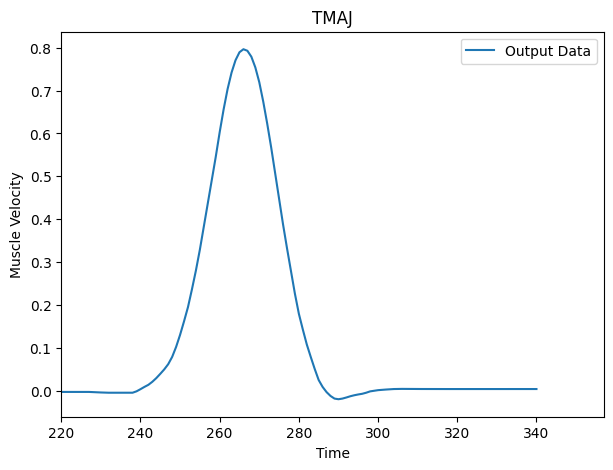

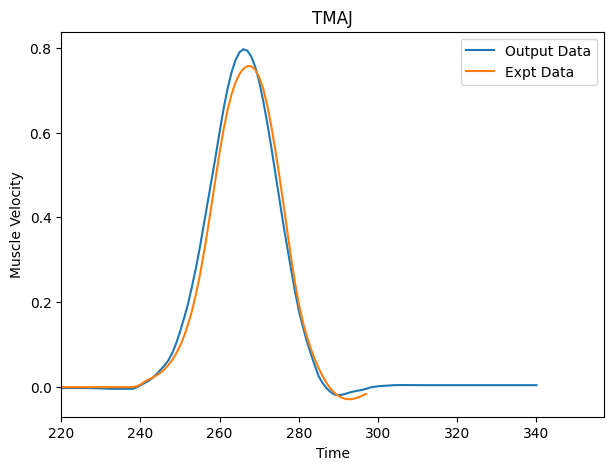

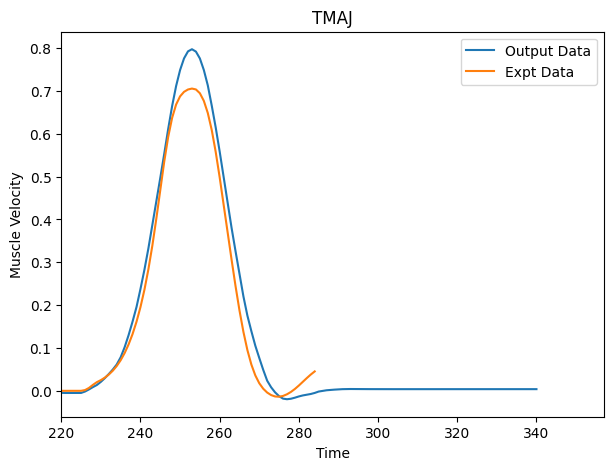

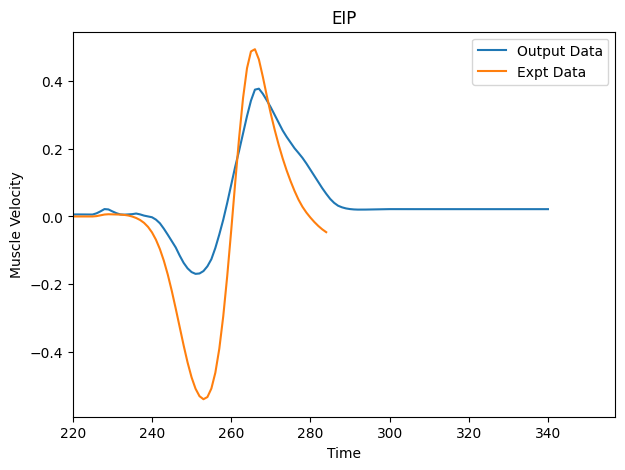

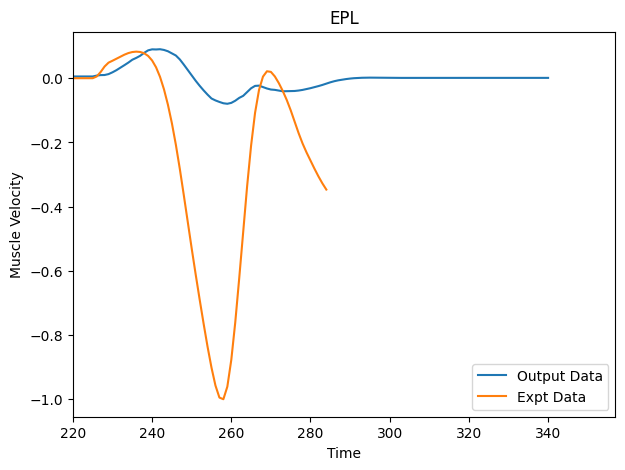

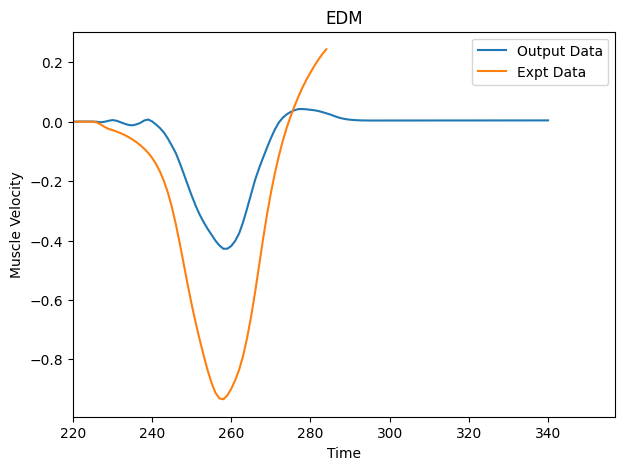

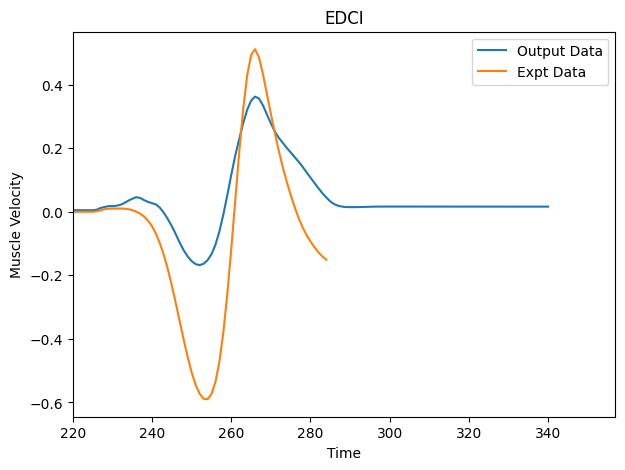

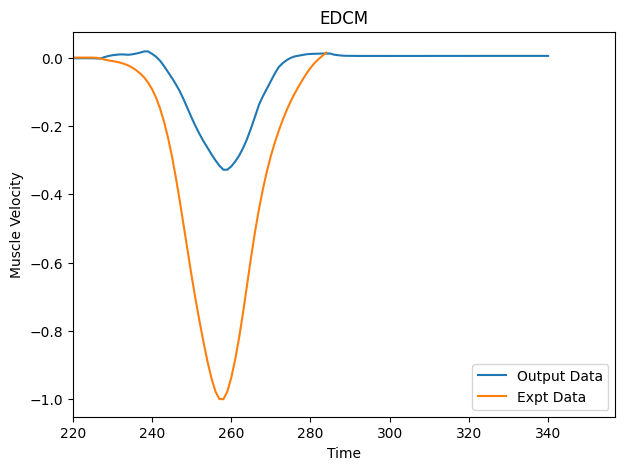

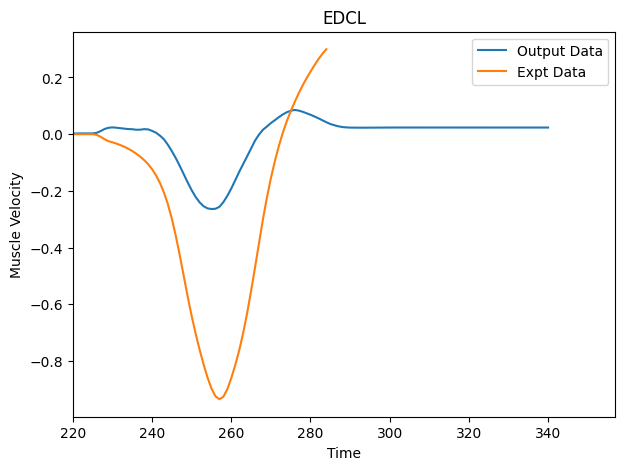

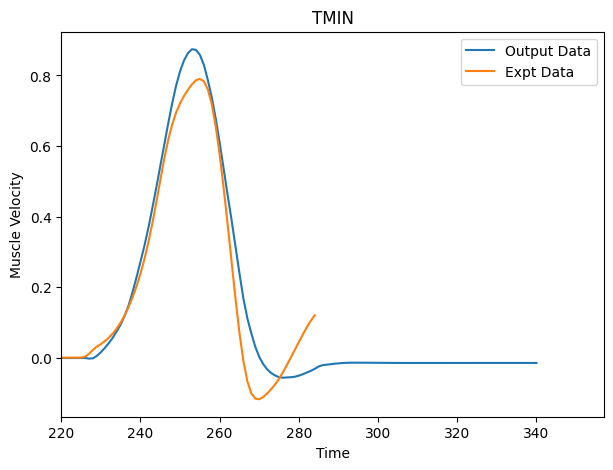

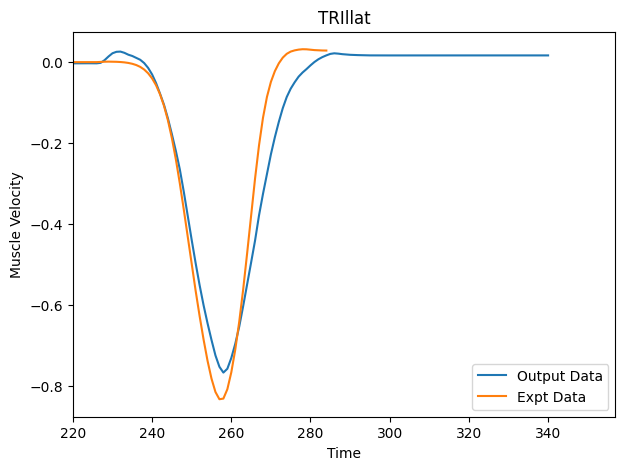

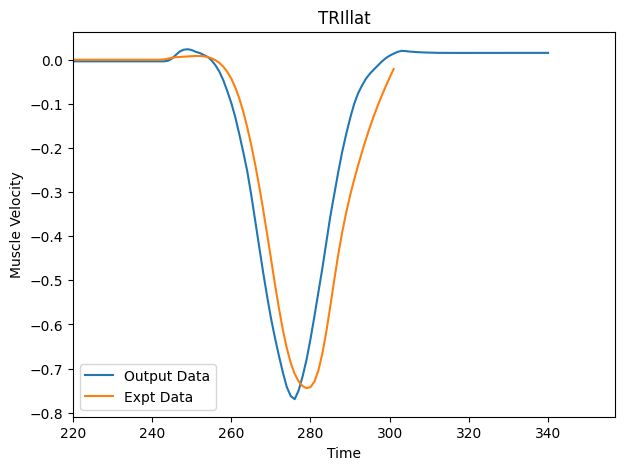

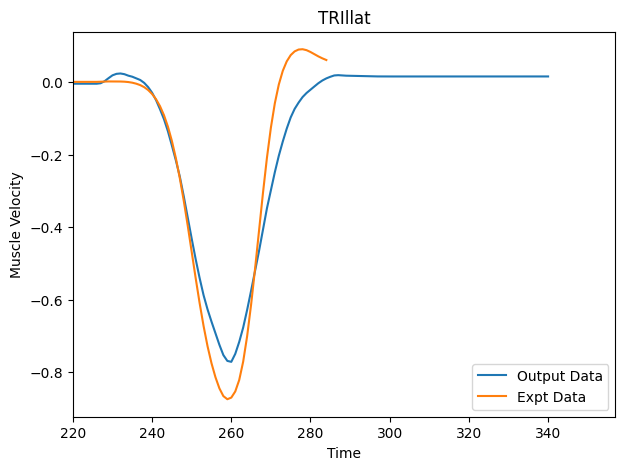

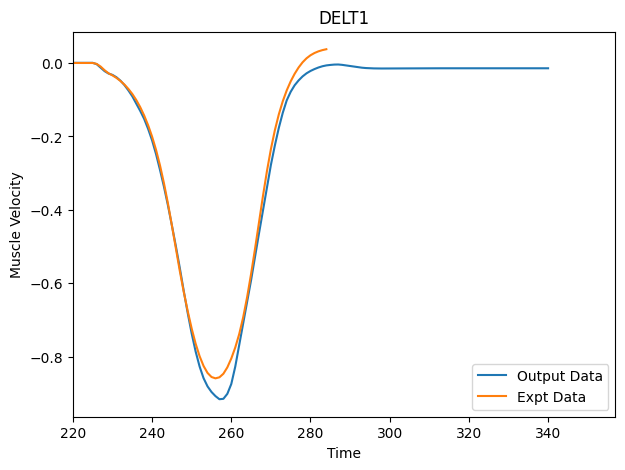

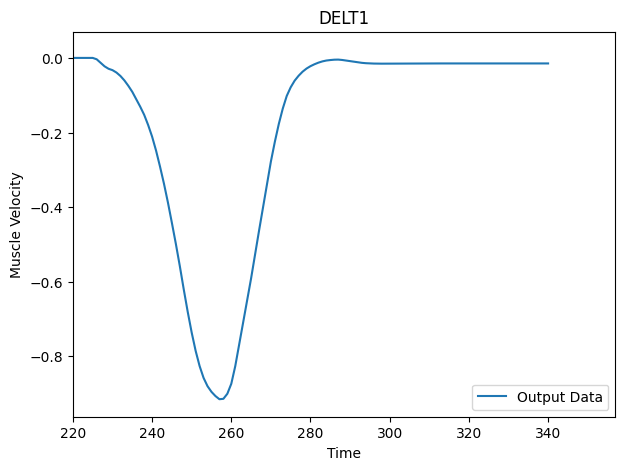

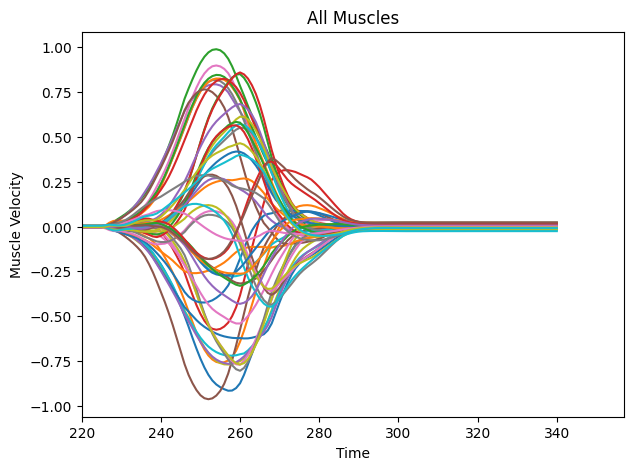

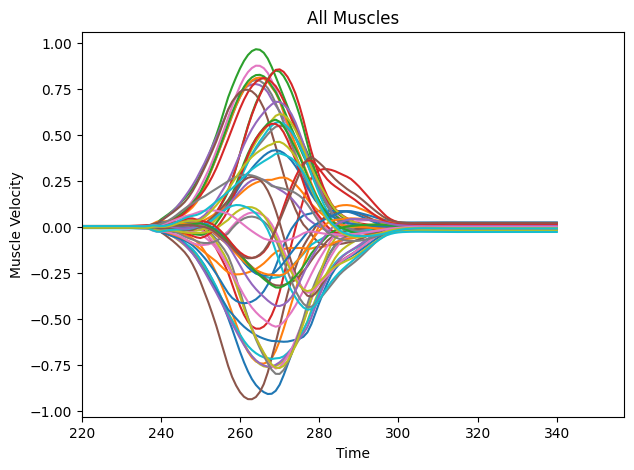

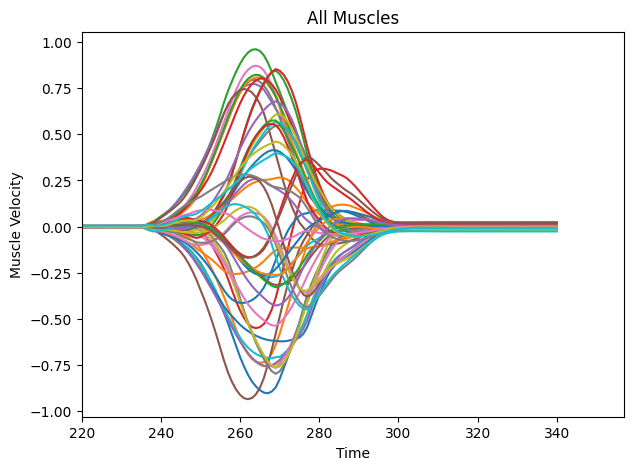

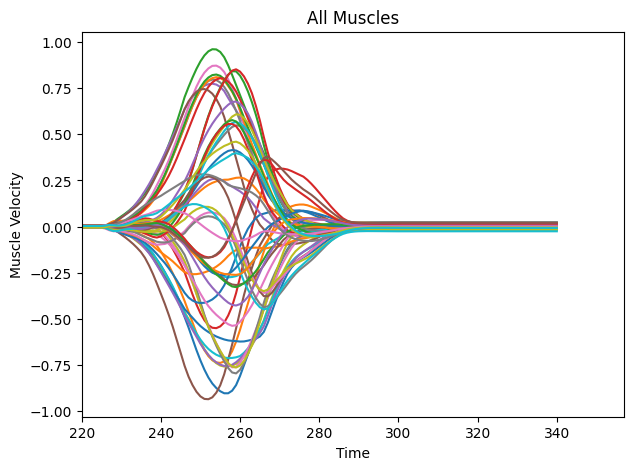

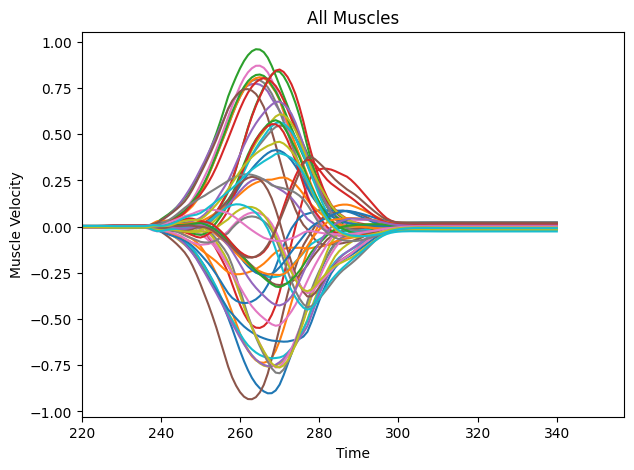

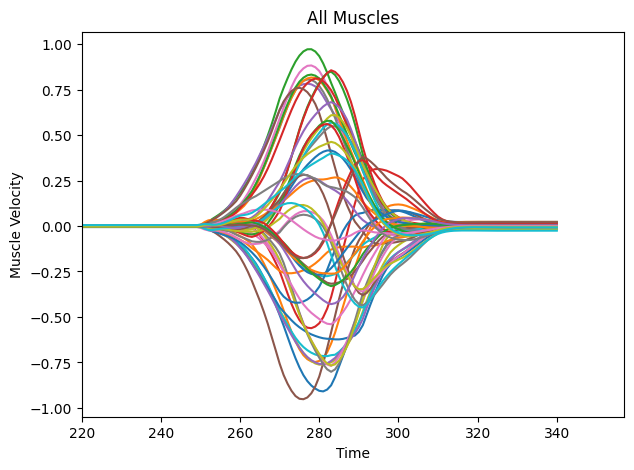

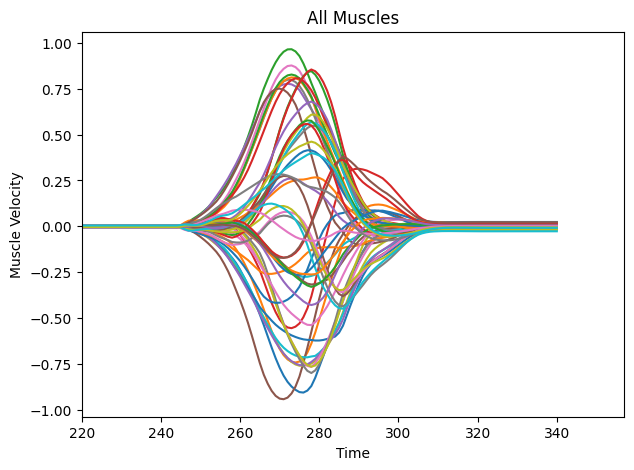

In [5]:
# Get relative path of gui file
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)

# "Experimental Data" TODO: Which trial to use? Some kind of average? How to account for differing hold signals?
exp_file_path = os.path.join(parent_directory, "model", "monkey_data.mat")
mat_data = scipy.io.loadmat(exp_file_path)
object_idxs = mat_data['trialInfo'][:,0]

output_file_path = os.path.join(parent_directory, 'model_outputs', 'TESTTHESE_backpad_longrun.pickle')
mvm_data_full = pd.read_pickle(output_file_path)

mvm_data_expt, mvm_data, trial_num = find_trial_from_object(object_idxs, 'abs1')


mvm_met_exp = mat_data['targ']
mvm_met_test = np.load(output_file_path, allow_pickle=True)
inp_data = mat_data['inp']
for ind,trash in enumerate(inp_data[0]):
    inp_data[0][ind] = inp_data[0][ind][20]
hold_data = inp_data[0]
# sophie change: this was pointing to an old image i think so i just changed the dir
object_folder_path = os.path.join(parent_directory, 'objects/old')

# SOPHIE CHANGE: I DON'T KNOW WHERE TO PUT THESE, THEY NEED TO CHANGE BASED ON MODEL, BUT TAKE TOO LONG
#       TO BE COMPUTED FOR EVERY REFRESH
ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[0])
ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[0])
ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[0], hold_data, hold_data)
ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[0])

# For plotting x-axis
time_axis = np.arange(2.2, 2.98, .01)

muscle_folder_path = os.path.join(parent_directory, 'muscles')
object_folder_path = os.path.join(parent_directory, 'objects')

# GUI Layout
left_column = [
    [sg.Canvas(size=(640, 480), key='-CANVAS-')],
    [sg.Column([
        [sg.Combo(object_list, key = '-OBJECTS-', default_value = 'abs1', enable_events=True, size=(10, 20))],
        [sg.Combo(muscle_list, key = '-MUSCLES-', default_value = 'All Muscles', enable_events=True, size=(10, 20))]
            ]),
    sg.Image(size=(300, 200), key='-MUSCLE_IMAGE-'), sg.Image(size = (50, 50), key = "-OBJECT_IMAGE-")]
]
metrics_define = [
        [sg.Text('')],
        [sg.Text('BradyKinesia Measurement')],
        [sg.Text('Hypokinesia Measurement')],
        [sg.Text('Akinesia Measurement')],
        [sg.Text('Tremor Factor')]
    ]
metrics_ground = [
        [sg.Text('Ground')],
        [sg.Text('0', key = 'ground_brady')],
        [sg.Text('0', key = 'ground_hypo')],
        [sg.Text('0', key = 'ground_akin')],
        [sg.Text('0', key = 'ground_tremor')]
    ]
metrics_model = [
        [sg.Text('Model')],
        [sg.Text('0', key = 'model_brady')],
        [sg.Text('0', key = 'model_hypo')],
        [sg.Text('0', key = 'model_akin')],
        [sg.Text('0', key = 'model_tremor')]
    ]
metrics_compare = [
        [sg.Text('Compare')],
        [sg.Text('0', key = 'compare_brady')],
        [sg.Text('0', key = 'compare_hypo')],
        [sg.Text('0', key = 'compare_akin')],
        [sg.Text('0', key = 'compare_tremor')]
    ]
# For slider tick marks
ticks = ['0', '25', '50', '75', '100']
right_column = [
    [sg.HSeparator()],
    [sg.Text('External Influence on the Model', justification='center', font=('Helvetica', 16, 'bold'))],  # TODO: NOT FUNCTIONAL
    [sg.Slider(range=(0,100), orientation='h', resolution=25, size=(30, 20), default_value=0, key='-SLIDER-', enable_events=True, expand_x=True, tick_interval=25)],
    [sg.VerticalSeparator(pad=(0, 20))],
    [sg.HSeparator()],
    [sg.Text("Show Other Models", justification='right', font=('Helvetica', 16, 'bold'))],  
    [sg.Checkbox("Experimental Data", key = "expt", enable_events= True), 
        sg.Checkbox('Healthy Model')], # TODO: NOT FUNCTIONAL
    [sg.VerticalSeparator(pad=(0, 20))],
    [sg.HSeparator()],
    [sg.Text('Metrics', justification='center', font=('Helvetica', 16, 'bold'))], # TODO: CURRENTLY RANDOM
    [sg.Column(metrics_define), sg.VSeparator(), sg.Column(metrics_ground), sg.VSeparator(), sg.Column(metrics_model), sg.VSeparator(), sg.Column(metrics_compare)],
    [sg.HSeparator()],
    [sg.Text('Console Output:',justification='center', font=('Helvetica', 16, 'bold'))],
    [sg.Output(size = (70, 5))],
]

# Final Layout
layout = [ [[sg.Text("Neuro Engineering Capstone", font='Any 20 bold')]],
    [sg.Column(left_column), sg.VSeperator(), sg.Column(right_column)], 
]
# Create the GUI window
window = sg.Window('DataFrame Plotter', layout)

# Initialize canvas and fig
canvas_elem = window['-CANVAS-']
fig = None
canvas = None
o_image = None
m_image = None
# Event loop
while True:
    event, values = window.read()
    if event == sg.WINDOW_CLOSED or event == 'Exit':
        if fig is not None:
            plt.close(fig)  # Close the figure to prevent it from being printed
        break
    elif event == 'expt':
        muscle_name = values['-MUSCLES-']
        if muscle_name == "All Muscles":

            window['expt'].update(False)
            print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
            continue
        else:
            fig = plot_data(mvm_data, muscle_name, values['expt'])
    elif event == "-OBJECTS-":
        o_image = object_image(values['-OBJECTS-'])
        window['-OBJECT_IMAGE-'].update(data=o_image)
        mvm_data_expt, mvm_data, first_trial_object = find_trial_from_object(object_idxs, values['-OBJECTS-'])
        fig = plot_data(mvm_data, muscle_name, values['expt'])

        # ground_brady_full, model_brady_full, p_val_brady = metrics.bradykinesia(mvm_met_test, mvm_met_exp[first_trial_object])
        # ground_hypo_full, model_hypo_full, p_val_hypo = metrics.hypokinesia(mvm_met_test, mvm_met_exp[first_trial_object])
        # ground_akin_full, model_akin_full, p_val_akin = metrics.akinesia(mvm_met_test, mvm_met_exp[first_trial_object], hold_data, hold_data)
        # ground_trem_full, model_trem_full, p_val_trem = metrics.tremor_factor(mvm_met_test, mvm_met_exp[first_trial_object])

        # Search through output data to find selected object ID trial (trial information)
        # Set data = output data
        # right now only done for mvm_data_expt, need to do for model output
        # TODO: Need to keep object information with the model output info 

    elif event == '-MUSCLES-':
        muscle_name = values['-MUSCLES-']
        if o_image is None:
            o_image = object_image(values['-OBJECTS-'])
            window['-OBJECT_IMAGE-'].update(data=o_image)
        if muscle_name == "All Muscles":
            fig = plot_data(mvm_data, muscle_name, values['expt'])
        else:
            # fig = plot_data(mvm_data.loc[muscle_name], muscle_name, values['expt']) 
            fig = plot_data(mvm_data, muscle_name, values['expt'])
        m_image = muscle_image(muscle_name,)
        window['-MUSCLE_IMAGE-'].update(data=m_image)

        # Random to implement GUI functionality. Change with Sophie's Super Statistics (SSS)
        ground_brady = round(ground_brady_full[muscle_dict[muscle_name]], 4)
        model_brady = round(model_brady_full[muscle_dict[muscle_name]], 4)

        
        ground_hypo = round(ground_hypo_full[muscle_dict[muscle_name]], 4)
        model_hypo = round(model_hypo_full[muscle_dict[muscle_name]], 4)

        ground_akin = round(ground_akin_full[muscle_dict[muscle_name]], 4)
        model_akin = round(model_akin_full[muscle_dict[muscle_name]], 4)

        ground_tremor = round(ground_trem_full[muscle_dict[muscle_name]], 4)
        model_tremor = round(model_trem_full[muscle_dict[muscle_name]], 4)

        window['ground_brady'].update(ground_brady)
        window['ground_hypo'].update(ground_hypo)
        window['ground_akin'].update(ground_akin)
        window['ground_tremor'].update(ground_tremor)

        window['model_brady'].update(model_brady)
        window['model_hypo'].update(model_hypo)
        window['model_akin'].update(model_akin)
        window['model_tremor'].update(model_tremor)

        window['compare_brady'].update(ground_brady - model_brady)
        window['compare_hypo'].update(ground_hypo - model_hypo)
        window['compare_akin'].update(ground_akin - model_akin)
        window['compare_tremor'].update(ground_tremor - model_tremor)

    # Update the plot in the GUI
    if fig is not None:
        if canvas:
            canvas.get_tk_widget().pack_forget()  # Remove the previous canvas
        canvas = FigureCanvasTkAgg(fig, canvas_elem.TKCanvas)
        canvas.draw()
        canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

    
window.close()


In [ ]:
# # SAVE



# # Muscle list for dropdown menu TODO: All muscles indexing is wrong 
# muscle_list = ['All Muscles', 'DELT1', 'DELT2', 'DELT3', 'SUPRA', 'INFRA', 'SUBSCAP', 'TMIN', 'TMAJ',
#                'PMAJ1', 'PMAJ2', 'PMAJ3', 'LAT1', 'LAT2', 'LAT3', 'CORB', 'TRIlong', 'TRIllat', 'TRIlmat', 
#                'ANC', 'SUP', 'BIClong', 'BICshort', 'BRA', 'BRD', 'ECRL', 'ECRB', 'ECU', 'FCR', 'FCU', 
#                'PL', 'PT', 'PQ', 'FDSL', 'FDSR', 'FDSM', 'FDSI', 'FDPL', 'FDPR', 'FDPM', 'FDPI',
#                'EDCL','EDCR', 'EDCM', 'EDCI', 'EDM', 'EIP', 'EPL', 'EPB', 'FPL', 'APL']

# muscle_dict = {muscle: index - 1 for index, muscle in enumerate(muscle_list)}

# # Object list for dropdown menu
# # object_list = ['Rings', 'Cubes', 'Balls', 'h.Cylinder', 'Boxes', 'v.Cylinder', 'Abstract']

# # Get relative path of gui file
# current_directory = os.getcwd()
# parent_directory = os.path.dirname(current_directory)

# # "Experimental Data" TODO: Which trial to use? Some kind of average? How to account for differing hold signals?
# exp_file_path = os.path.join(parent_directory, "model", "monkey_data.mat")
# mat_data = scipy.io.loadmat(exp_file_path)
# mvm_data_expt = mat_data['targ'][0][0]
# mvm_data_expt = pd.DataFrame(mvm_data_expt, index = muscle_list[1:])

# # Load the our output data. TODO: Right now it is one file, we need to change to adjust for object list AND increase in lesions
# output_file_path = os.path.join(parent_directory, "model", "generated_outputs_new.pkl")
# mvm_data = pd.read_pickle(output_file_path)

# # TODO: What trial to use? First trial 
# mvm_data = mvm_data[0]

# # For plotting x-axis
# time_axis = np.arange(2.2, 2.98, .01)

# def plot_data(output_data, muscle, expt_data):
#     if muscle_dict[muscle] > -1:

#         output_data = output_data[:, muscle_dict[muscle]]
#     else: 
#         # TODO: Figure out what to do here. We want to prevent the user from selecting All Muscles *while* expt_data is already selected
#         # (and therefore a single muscle was already selected). How/Should we go back to the single muscle or should we deselect the expt_data
#         # if expt_data:
#         #     print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
#         #     pass    
#         output_data = output_data
#     # output_data = output_data[220:]
#     output_data.tolist()
#     fig, ax = plt.subplots(figsize=(7, 5))
#     ax.plot(output_data, label = "Output Data")
#     if expt_data:
#         expt_data_plot = mvm_data_expt.loc[muscle_name]
#         # expt_data_plot = expt_data_plot[220:298]
#         ax.plot(expt_data_plot, label = "Expt Data")
#     ax.set_xlabel('Time')
#     ax.set_ylabel('Muscle Velocity')
#     ax.set_title(muscle_name)
#     ax.set_xlim(left = 220)
#     if muscle_dict[muscle] > -1: # im so sorry code quality 
#         plt.legend()
#     return fig

# muscle_folder_path = os.path.join(parent_directory, 'muscles')
# object_folder_path = os.path.join(parent_directory, 'objects')

# # Function to find muscle_image
# def muscle_image(muscle_name):
#     if muscle_name is None:
#         muscle_name = 'DELT1'
#     muscle_file_path = os.path.join(muscle_folder_path, muscle_name + '.png')
#     size = (450, 150)
#     im = Image.open(muscle_file_path)
#     # im = im.crop((102,202,1002,502))
# # cropped = im.crop((0, 0, 200, 200))
# # tk_im = ImageTk.PhotoImage(cropped)

    
#     im = im.resize(size, resample=Image.BICUBIC)
#     return ImageTk.PhotoImage(image = im)

# # Function to find muscle_image
# def object_image(object_name):
#     object_file_path = os.path.join(object_folder_path, object_name + '.png')
#     print(object_file_path)
#     size = (150, 150)
#     im = Image.open(object_file_path)
#     im = im.resize(size, resample=Image.BICUBIC)
#     return ImageTk.PhotoImage(image = im)

# # GUI Layout
# left_column = [
#     [sg.Canvas(size=(640, 480), key='-CANVAS-')],
#     [sg.Column([
#         [sg.Combo(object_list, key = '-OBJECTS-', default_value = 'Rings', enable_events=True, size=(10, 20))],
#         [sg.Combo(muscle_list, key = '-MUSCLES-', default_value = 'All Muscles', enable_events=True, size=(10, 20))]
#             ]),
#     sg.Image(size=(300, 200), key='-MUSCLE_IMAGE-'), sg.Image(size = (50, 50), key = "-OBJECT_IMAGE-")]
# ]
# metrics_define = [
#         [sg.Text('')],
#         [sg.Text('BradyKinesia Measurement')],
#         [sg.Text('Hypokinesia Measurement')],
#         [sg.Text('Akinesia Measurement')],
#         [sg.Text('Tremor Factor')]
#     ]
# metrics_ground = [
#         [sg.Text('Ground')],
#         [sg.Text('0', key = 'ground_brady')],
#         [sg.Text('0', key = 'ground_hypo')],
#         [sg.Text('0', key = 'ground_akin')],
#         [sg.Text('0', key = 'ground_tremor')]
#     ]
# metrics_model = [
#         [sg.Text('Model')],
#         [sg.Text('0', key = 'model_brady')],
#         [sg.Text('0', key = 'model_hypo')],
#         [sg.Text('0', key = 'model_akin')],
#         [sg.Text('0', key = 'model_tremor')]
#     ]
# metrics_compare = [
#         [sg.Text('Compare')],
#         [sg.Text('0', key = 'compare_brady')],
#         [sg.Text('0', key = 'compare_hypo')],
#         [sg.Text('0', key = 'compare_akin')],
#         [sg.Text('0', key = 'compare_tremor')]
#     ]
# # For slider tick marks
# ticks = ['0', '25', '50', '75', '100']
# right_column = [
#     [sg.HSeparator()],
#     [sg.Text('External Influence on the Model', justification='center', font=('Helvetica', 16, 'bold'))],  # TODO: NOT FUNCTIONAL
#     [sg.Slider(range=(0,100), orientation='h', resolution=25, size=(30, 20), default_value=0, key='-SLIDER-', enable_events=True, expand_x=True, tick_interval=25)],
#     [sg.VerticalSeparator(pad=(0, 20))],
#     [sg.HSeparator()],
#     [sg.Text("Show Other Models", justification='right', font=('Helvetica', 16, 'bold'))],  
#     [sg.Checkbox("Experimental Data", key = "expt", enable_events= True), 
#         sg.Checkbox('Healthy Model')], # TODO: NOT FUNCTIONAL
#     [sg.VerticalSeparator(pad=(0, 20))],
#     [sg.HSeparator()],
#     [sg.Text('Metrics', justification='center', font=('Helvetica', 16, 'bold'))], # TODO: CURRENTLY RANDOM
#     [sg.Column(metrics_define), sg.VSeparator(), sg.Column(metrics_ground), sg.VSeparator(), sg.Column(metrics_model), sg.VSeparator(), sg.Column(metrics_compare)],
#     [sg.HSeparator()],
#     [sg.Text('Console Output:',justification='center', font=('Helvetica', 16, 'bold'))],
#     [sg.Output(size = (70, 5))],
# ]

# # Final Layout
# layout = [ [[sg.Text("Neuro Engineering Capstone", font='Any 20 bold')]],
#     [sg.Column(left_column), sg.VSeperator(), sg.Column(right_column)], 
# ]
# # Create the GUI window
# window = sg.Window('DataFrame Plotter', layout)

# # Initialize canvas and fig
# canvas_elem = window['-CANVAS-']
# fig = None
# canvas = None
# o_image = None
# m_image = None
# # Event loop
# while True:
#     event, values = window.read()
#     if event == sg.WINDOW_CLOSED or event == 'Exit':
#         if fig is not None:
#             plt.close(fig)  # Close the figure to prevent it from being printed
#         break
#     elif event == 'expt':
#         muscle_name = values['-MUSCLES-']
#         if muscle_name == "All Muscles":

#             window['expt'].update(False)
#             print("Cannot display expt data against All Muscles. Please select a different muscle and try again")
#             continue
#         else:
#             fig = plot_data(mvm_data, muscle_name, values['expt'])
#     elif event == "-OBJECTS-":
#         o_image = object_image(values['-OBJECTS-'])
#         window['-OBJECT_IMAGE-'].update(data=o_image)
#     elif event == '-MUSCLES-':
#         muscle_name = values['-MUSCLES-']
#         if o_image is None:
#             o_image = object_image(values['-OBJECTS-'])
#             window['-OBJECT_IMAGE-'].update(data=o_image)
#         if muscle_name == "All Muscles":
#             fig = plot_data(mvm_data, muscle_name, values['expt'])
#         else:
#             # fig = plot_data(mvm_data.loc[muscle_name], muscle_name, values['expt']) 
#             fig = plot_data(mvm_data, muscle_name, values['expt'])
#         m_image = muscle_image(muscle_name,)
#         window['-MUSCLE_IMAGE-'].update(data=m_image)

#         # Random to implement GUI functionality. Change with Sophie's Super Statistics (SSS)
#         ground_brady = random.randint(0, 100)
#         ground_hypo = random.randint(0, 100)
#         ground_akin = random.randint(0, 100)
#         ground_tremor = random.randint(0, 100)

#         model_brady = random.randint(0, 100)
#         model_hypo = random.randint(0, 100)
#         model_akin = random.randint(0, 100)
#         model_tremor = random.randint(0, 100)

#         window['ground_brady'].update(ground_brady)
#         window['ground_hypo'].update(ground_hypo)
#         window['ground_akin'].update(ground_akin)
#         window['ground_tremor'].update(ground_tremor)

#         window['model_brady'].update(model_brady)
#         window['model_hypo'].update(model_hypo)
#         window['model_akin'].update(model_akin)
#         window['model_tremor'].update(model_tremor)

#         window['compare_brady'].update(ground_brady - model_brady)
#         window['compare_hypo'].update(ground_hypo - model_hypo)
#         window['compare_akin'].update(ground_akin - model_akin)
#         window['compare_tremor'].update(ground_tremor - model_tremor)

#     # Update the plot in the GUI
#     if fig is not None:
#         if canvas:
#             canvas.get_tk_widget().pack_forget()  # Remove the previous canvas
#         canvas = FigureCanvasTkAgg(fig, canvas_elem.TKCanvas)
#         canvas.draw()
#         canvas.get_tk_widget().pack(side='top', fill='both', expand=1)

    
# window.close()


In [ ]:
idx = 0
trial_info = (mat_data["trialInfo"])
norm = trial_info[idx][0]
if norm > 80:
    norm -= 10
norm -= 21
fact = norm // 10
norm = fact * 6 + norm % 10

In [ ]:
object_dict = {
    92: 'abs1',
    94: 'abs2',
    93: 'abs3',
    95: 'abs4',
    96: 'abs5',
    91: 'abs6',

    51: 'hcyl1',
    52: 'hcyl2',
    12: 'hcyl3',
    53: 'hcyl4',
    54: 'hcyl5',
    55: 'hcyl6',
    56: 'hcyl7',

    15: 'box1',
    61: 'box2',
    62: 'box3',
    63: 'box4',
    64: 'box5',
    65: 'box6',
    66: 'box7',

    16: 'ring5',
    24: 'ring4',
    25: 'ring6',
    26: 'ring7',
    23: 'ring3',
    21: 'ring1',
    22: 'ring2',

    71: 'vcyl1',
    72: 'vcyl2',
    73: 'vcyl3',
    74: 'vcyl4',
    75: 'vcyl5',
    76: 'vcyl6',

    11: 'sphere1',
    41: 'sphere2',
    14: 'sphere5',
    44: 'sphere6',
    42: 'sphere3',
    43: 'sphere4',
    45: 'sphere7',
    46: 'sphere8',

    31: 'cube1',
    32: 'cube2',
    13: 'cube4',
    33: 'cube5',
    35: 'cube6',
    36: 'cube3',
    34: 'cube7',
    }

object_dict_flipped = {value: key for key, value in object_dict.items()}
object_list = list(object_dict_flipped.keys())
object_list

with open("object_dict.json", "w") as outfile: 
    json.dump(object_dict, outfile)

In [ ]:
# "Experimental Data" TODO: Which trial to use? Some kind of average? How to account for differing hold signals?
exp_file_path = os.path.join(parent_directory, "model", "monkey_data.mat")
mat_data = scipy.io.loadmat(exp_file_path)
mvm_data_expt = mat_data['targ'][0][0]
print(mvm_data_expt.shape)
mvm_data_expt = pd.DataFrame(mvm_data_expt, index = muscle_list[1:])

In [ ]:
mvm_data_expt

In [ ]:
mvm_data_expt = find_trial_from_object(object_idxs, 'abs1')

mvm_data_expt.shape

In [ ]:
data = mat_data['targ'][0][int(indexes[0][0])]
data.shape

In [ ]:
output_file_path = os.path.join(parent_directory, "model", "generated_outputs.pkl")
mvm_data = pd.read_pickle(output_file_path)

In [ ]:
output_file_path = os.path.join(parent_directory, 'model', 'weighted_loss_model_outputs.pickle')
mvm_data = pd.read_pickle(output_file_path)

# TODO: What trial to use? First trial 
mvm_data = mvm_data[17]
mvm_data.shape

In [ ]:
mvm_data_expt.shape